In [2]:
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import os
import pickle
import numpy as np
from tqdm import tqdm

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def evaluate(prediction_rate,X,Y,xgb_model_loaded,junction):
    history = [0]  # Assuming no incident at start
    incident_counter = 0
    detected_counter = 0
    new_incident_flag = False
    incident_detected_flag = False
    predictions_count = 0
    i = 0  # Time since last new incident
    false_alarm_counter = 0
    detection_times = []  # To calculate mean time for detection
    counter = 1
    for row,yrow in tqdm(zip(X,Y)):
        
        if counter% prediction_rate == 0:
            
            predictions_count+=1
            predicted = xgb_model_loaded.predict([row])[0] 
            # print(predicted)
            
            if len(history) > 0:
                previous_label = history[-1]
            else:
                previous_label = 0  # Default to no incident for the first element

            # Update history
            current_label = 1 if yrow else 0
            history.append(current_label)

            # New incident started
            if previous_label == 0 and current_label == 1:
                incident_counter += 1
                new_incident_flag = True
                incident_detected_flag = False  # Reset detection flag for new incident
                i = 0  # Reset timer for new incident
                # print("New incident started")

            # Incident detected
            if new_incident_flag and predicted == 1 and not incident_detected_flag:
                detected_counter += 1
                detection_times.append(i)
                incident_detected_flag = True
                # print(f"Incident Detected by model after {i} timesteps.")

            # Incident finished
            if previous_label == 1 and current_label == 0:
                new_incident_flag = False
                # print("Incident Finished")


            # False alarm raised
            if not new_incident_flag and predicted == 1 and not (1 in history[-1000:]):
                false_alarm_counter += 1
                
        # Increment timer if incident ongoing but not yet detected
        if new_incident_flag and not incident_detected_flag:
            i += 1
        counter+=1
        
    false_alarm_rate = 100*false_alarm_counter/predictions_count
    arr = np.array(detection_times)
    row = {
             "junctions" : junction,
            "prediction_rate" : prediction_rate, 
           "incident_counter": incident_counter,
           "detected_counter":detected_counter,
           "mttd":arr.mean(),
           "false_alarm_counter":false_alarm_counter,
           "false_alarm_rate": false_alarm_rate,
           "predictions_count":predictions_count
        
    }    
    return row

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
model_path = "/home/local/ASURITE/speddira/dev/traffic_sense_net/city_scale/wild_models/saved_models/tab_net_8_jun.zip"
loaded_clf = TabNetClassifier()
loaded_clf.load_model(model_path)

/home/local/ASURITE/speddira/miniconda3/envs/cobra/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [6]:
df = pd.read_csv("/home/local/ASURITE/speddira/dev/traffic_sense_net/city_scale/processed_datasets/2024-2-16_1915hours_8jun_600_win_600twin.csv")

/tmp/ipykernel_2836919/1740528188.py:1: DtypeWarning: Columns (129,131,132,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/local/ASURITE/speddira/dev/traffic_sense_net/city_scale/processed_datasets/2024-2-16_1915hours_8jun_600_win_600twin.csv")


In [7]:
df.isna().sum()

Unnamed: 0                              0
step                                    0
rolling_junction_mean_speed_0         708
rolling_traffic_count_0               708
rolling_traffic_occupancy_0           708
rolling_junction_mean_speed_1         708
rolling_traffic_count_1               708
rolling_traffic_occupancy_1           708
rolling_junction_mean_speed_2         708
rolling_traffic_count_2               708
rolling_traffic_occupancy_2           708
rolling_junction_mean_speed_3         708
rolling_traffic_count_3               708
rolling_traffic_occupancy_3           708
rolling_junction_mean_speed_4         708
rolling_traffic_count_4               708
rolling_traffic_occupancy_4           708
rolling_junction_mean_speed_5         708
rolling_traffic_count_5               708
rolling_traffic_occupancy_5           708
rolling_junction_mean_speed_6         708
rolling_traffic_count_6               708
rolling_traffic_occupancy_6           708
rolling_junction_mean_speed_7     

In [8]:
df.head()

,Unnamed: 0,step,rolling_junction_mean_speed_0,rolling_traffic_count_0,rolling_traffic_occupancy_0,rolling_junction_mean_speed_1,rolling_traffic_count_1,rolling_traffic_occupancy_1,rolling_junction_mean_speed_2,rolling_traffic_count_2,rolling_traffic_occupancy_2,rolling_junction_mean_speed_3,rolling_traffic_count_3,rolling_traffic_occupancy_3,rolling_junction_mean_speed_4,rolling_traffic_count_4,rolling_traffic_occupancy_4,rolling_junction_mean_speed_5,rolling_traffic_count_5,rolling_traffic_occupancy_5,rolling_junction_mean_speed_6,rolling_traffic_count_6,rolling_traffic_occupancy_6,rolling_junction_mean_speed_7,rolling_traffic_count_7,rolling_traffic_occupancy_7,rolling_junction_mean_speed_8,rolling_traffic_count_8,rolling_traffic_occupancy_8,rolling_junction_mean_speed_9,rolling_traffic_count_9,rolling_traffic_occupancy_9,rolling_junction_mean_speed_10,rolling_traffic_count_10,rolling_traffic_occupancy_10,rolling_junction_mean_speed_11,rolling_traffic_count_11,rolling_traffic_occupancy_11,rolling_junction_mean_speed_12,rolling_traffic_count_12,rolling_traffic_occupancy_12,rolling_junction_mean_speed_13,rolling_traffic_count_13,rolling_traffic_occupancy_13,rolling_junction_mean_speed_14,rolling_traffic_count_14,rolling_traffic_occupancy_14,rolling_junction_mean_speed_15,rolling_traffic_count_15,rolling_traffic_occupancy_15,rolling_junction_mean_speed_16,rolling_traffic_count_16,rolling_traffic_occupancy_16,rolling_junction_mean_speed_17,rolling_traffic_count_17,rolling_traffic_occupancy_17,rolling_junction_mean_speed_18,rolling_traffic_count_18,rolling_traffic_occupancy_18,rolling_junction_mean_speed_19,rolling_traffic_count_19,rolling_traffic_occupancy_19,rolling_junction_mean_speed_20,rolling_traffic_count_20,rolling_traffic_occupancy_20,rolling_junction_mean_speed_21,rolling_traffic_count_21,rolling_traffic_occupancy_21,rolling_junction_mean_speed_22,rolling_traffic_count_22,rolling_traffic_occupancy_22,rolling_junction_mean_speed_23,rolling_traffic_count_23,rolling_traffic_occupancy_23,rolling_junction_mean_speed_24,rolling_traffic_count_24,rolling_traffic_occupancy_24,rolling_junction_mean_speed_25,rolling_traffic_count_25,rolling_traffic_occupancy_25,rolling_junction_mean_speed_26,rolling_traffic_count_26,rolling_traffic_occupancy_26,rolling_junction_mean_speed_27,rolling_traffic_count_27,rolling_traffic_occupancy_27,rolling_junction_mean_speed_28,rolling_traffic_count_28,rolling_traffic_occupancy_28,rolling_junction_mean_speed_29,rolling_traffic_count_29,rolling_traffic_occupancy_29,rolling_junction_mean_speed_30,rolling_traffic_count_30,rolling_traffic_occupancy_30,rolling_junction_mean_speed_31,rolling_traffic_count_31,rolling_traffic_occupancy_31,rolling_junction_mean_speed_32,rolling_traffic_count_32,rolling_traffic_occupancy_32,rolling_junction_mean_speed_33,rolling_traffic_count_33,rolling_traffic_occupancy_33,rolling_junction_mean_speed_34,rolling_traffic_count_34,rolling_traffic_occupancy_34,rolling_junction_mean_speed_35,rolling_traffic_count_35,rolling_traffic_occupancy_35,rolling_junction_mean_speed_36,rolling_traffic_count_36,rolling_traffic_occupancy_36,rolling_junction_mean_speed_37,rolling_traffic_count_37,rolling_traffic_occupancy_37,rolling_junction_mean_speed_38,rolling_traffic_count_38,rolling_traffic_occupancy_38,rolling_junction_mean_speed_39,rolling_traffic_count_39,rolling_traffic_occupancy_39,rolling_junction_mean_speed_40,rolling_traffic_count_40,rolling_traffic_occupancy_40,rolling_junction_mean_speed_41,rolling_traffic_count_41,rolling_traffic_occupancy_41,time_of_day,incident_edge,incident_start_time,incident_type,accident_id,accident_duration,incident_lane,accident_label,rolling_travel_time_3_5,rolling_travel_time_10_4,rolling_travel_time_8_11,rolling_travel_time_14_9,rolling_travel_time_30_33,rolling_travel_time_38_31,rolling_travel_time_34_39,rolling_travel_time_42_35,rolling_travel_time_32_2,rolling_travel_time_1_29,rolling_travel_time_26_13,rolling_travel_time_12_27,rolling_travel_time

In [9]:
df.shape

(3392182, 160)

In [10]:
df_eval =df.drop(["Unnamed: 0", "step"],axis=1)

In [11]:
def standardize(col):
   return (col - col.mean()) / col.std()


In [12]:
# IF detecting incidents
df_eval = df_eval[600:]
df_eval =df_eval.fillna(-1)

Y = df_eval["accident_label"]

In [13]:
X = df_eval.drop(["incident_edge","incident_start_time","incident_type","accident_id","accident_duration","incident_lane","accident_label"],axis=1)
X = X.apply(standardize)

In [14]:
X= X.values
Y= Y.values

In [15]:
X.shape

(3391582, 151)

In [16]:
# Direct Evaluation - but in reality we run prediction every 1 minute and when an incident flag is raised and detected we have a cooling period after incident clearance
y_pred = loaded_clf.predict(X)
y_pred = list(y_pred)
y_test = list(Y)

accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy))
print(f"FAR {100-accuracy}")
print("precision: %.2f%%" % (precision * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
print("recall: %.2f%%" % (recall * 100.0))

Accuracy: 93.85%
FAR 6.147426186363774
precision: 94.27%
f1: 92.70%
recall: 91.17%


In [17]:
junction = 4
print(evaluate(30,X,Y,loaded_clf,junction))

0it [00:00, ?it/s]

2021310it [05:52, 5733.94it/s]


KeyboardInterrupt: 

In [18]:
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("auc_score: %.2f%%" % (auc_score * 100.0))

auc_score: 93.51%


<Axes: >

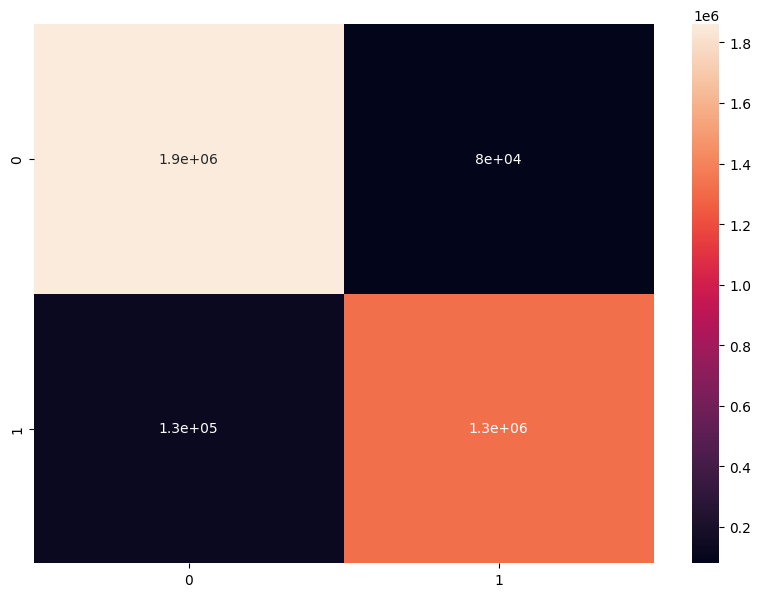

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True)


In [20]:
matrix

array([[1859820,   80365],
       [ 128130, 1323267]])